In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import os
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight

from tensorflow import keras
from tensorflow.keras import layers, regularizers  ### Adding 'regularizers'
from tensorflow.keras.models import Sequential
import pathlib
import zipfile

2024-11-30 17:06:01.100177: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-30 17:06:01.377216: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-30 17:06:01.445948: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-30 17:06:01.939945: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
noted_path = os.getcwd()
noted_path

'/sfs/gpfs/tardis/home/waa4bq/Documents/MSDS/6050 Deep Learning/DS6050_Project'

### **Helper Functions**

In [26]:
### Plot Helper
def visualize_model_results(model_input):
    acc = model_input.history['accuracy']
    val_acc = model_input.history['val_accuracy']

    loss = model_input.history['loss']
    val_loss = model_input.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2,1,2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

**<span style="color:#180842; font-size:26px">
Second Train/Validation Data Set
</span>** <br>

In [66]:
# test_dataset_url = "https://dl.dropboxusercontent.com/scl/fi/nyv6xg7u0lj5uv5jtglto/test_google_images_landslide_three.zip?rlkey=b7xnjid2s7zvfjbp0oqtji084&dl=0?raw=1"

test_dataset_url = "https://dl.dropboxusercontent.com/s/0en4k86c1r1uzs0/test_google_images_landslides_four.zip?st=pdg6yhzj&dl=0?raw=1?raw=1"


In [67]:
data_dir_two = tf.keras.utils.get_file('test_google_images_landslides_four.zip', origin=test_dataset_url, extract=True)
data_dir_two = pathlib.Path(data_dir_two).with_suffix('')

In [68]:
## Review folders in incoming data / classes
folders_two = [folder for folder in data_dir_two.glob('*') if folder.is_dir()]
print("Folders in the test directory:")
for folder in folders_two:
    print(folder.name)

Folders in the test directory:
Google_Earth_Images
Test_Images_Duplicates


In [69]:
# Drill into each subdirectory and list files
for folder in folders_two:
    print(f"\nContents of folder '{folder.name}':")
    for subitem in folder.iterdir():
        if subitem.is_file():
            print(f"  File: {subitem.name}")
        elif subitem.is_dir():
            print(f"  Subfolder: {subitem.name}")
            count = len(list(subitem.glob('*.jpg')))
            print(f"{subitem.name}: {count} .jpg images")


Contents of folder 'Google_Earth_Images':
  Subfolder: landslides
landslides: 57 .jpg images
  Subfolder: non-landslides
non-landslides: 73 .jpg images
  File: .DS_Store

Contents of folder 'Test_Images_Duplicates':
  File: nasa_g_4263m_12654_2023_cat.jpg
  File: nasa_g_3015m_12654_2023_cat.jpg
  File: nasa_g_4161m_11542_2021_cat.jpg
  File: nasa_g_2785m_11542_2021_cat_town.jpg
  File: nasa_g_4800m_10029_2019_vylg.jpg
  File: nasa_g_4800m_9304_2017_vylg.jpg
  File: nasa_g_4250m_12699_2019_large_v2.jpg


In [70]:
print(data_dir_two)

/home/waa4bq/.keras/datasets/test_google_images_landslides_four_extracted


In [75]:
## Update Directory
data_dir_two_alt_path = '/home/waa4bq/.keras/datasets/test_google_images_landslides_four_extracted/Google_Earth_Images'
print(data_dir_two_alt_path)

/home/waa4bq/.keras/datasets/test_google_images_landslides_four_extracted/Google_Earth_Images


**<span style="color:#180842; font-size:26px">
Set Training/Validation Data & Split
</span>** <br>

In [106]:
## Set Batch and Image size. 
batch_size = 16
img_height = 300
img_width = 300

#### Create Training / Validation Sets

In [107]:
## Set Training Set image set. 
train_dataset_two = tf.keras.utils.image_dataset_from_directory(
  data_dir_two_alt_path,
  validation_split=0.35,
  subset="training",
  seed=910,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 130 files belonging to 2 classes.
Using 85 files for training.


In [108]:
## Setup Valiation set.
valid_dataset_two = tf.keras.utils.image_dataset_from_directory(
  data_dir_two_alt_path,
  validation_split=0.35,
  subset="validation",
  seed=910,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 130 files belonging to 2 classes.
Using 45 files for validation.


In [109]:
# Count the total samples in training and validation sets
train_count = sum(1 for _ in train_dataset_two.unbatch())
valid_count = sum(1 for _ in valid_dataset_two.unbatch())

# Initialize class counters
train_class_counts = {}
valid_class_counts = {}

# Function to count samples per class
def count_classes(dataset, class_counts):
    for _, labels in dataset.unbatch():
        label = int(labels.numpy())
        if label not in class_counts:
            class_counts[label] = 0
        class_counts[label] += 1

# Count samples in training and validation datasets
count_classes(train_dataset_two, train_class_counts)
count_classes(valid_dataset_two, valid_class_counts)

# Display counts
print(f"Training set size: {train_count}")
print(f"Validation set size: {valid_count}")
print("\nClass distribution in Training set:")
for class_label, count in sorted(train_class_counts.items()):
    print(f"  Class {class_label}: {count} samples")

print("\nClass distribution in Validation set:")
for class_label, count in sorted(valid_class_counts.items()):
    print(f"  Class {class_label}: {count} samples")

Training set size: 85
Validation set size: 45

Class distribution in Training set:
  Class 0: 39 samples
  Class 1: 46 samples

Class distribution in Validation set:
  Class 0: 18 samples
  Class 1: 27 samples


## Buffering/Shuffle

In [110]:
## Data Performance
AUTOTUNE = tf.data.AUTOTUNE

train_dataset_two = train_dataset_two.cache().shuffle(50).prefetch(buffer_size=AUTOTUNE)
valid_dataset_two = valid_dataset_two.cache().prefetch(buffer_size=AUTOTUNE)

2024-11-30 17:26:49.536262: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


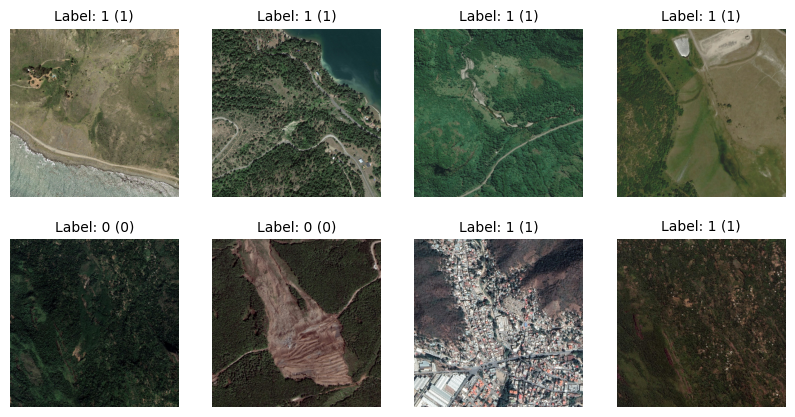

In [111]:
## Checking Images and Labels:
plt.figure(figsize=(10, 5))
for images, labels in train_dataset_two.take(1):  # Take one batch
    for i in range(8):  # Display first 6 samples
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label = labels[i].numpy()
        label_name = class_names[label] if 'class_names' in locals() else label
        plt.title(f"Label: {label} ({label_name})", fontsize=10)
        plt.axis("off")
plt.show()

<hr style="border:8px solid #301b66">

### **Class Weights for use during Model Fit**
- Added code to create Class Weights (class_weight=class_weight,) that you may use during the Model Fit process. 
- https://keras.io/examples/structured_data/imbalanced_classification/

In [112]:
# Assuming `train_dataset` is your dataset and you have class labels as `y_train`
class_labels = np.concatenate([y.numpy() for _, y in train_dataset_two])

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',  # Option to use 'balanced' or specify manual weights
    classes=np.unique(class_labels),
    y=class_labels
)

# Convert to a dictionary (Keras expects this format)
class_weights_dict_goog = dict(enumerate(class_weights))

print("Class weights:", class_weights_dict_goog)

Class weights: {0: 1.0897435897435896, 1: 0.9239130434782609}


<hr style="border:8px solid #301b66">

**<span style="color:#0638b2; font-size:30px">
Load Saved Keras Model and Further Train
</span>** <br>


In [133]:
reconstruct_path = (f'{noted_path}/ENB3_One_hh.keras')
reconstruct_path

'/sfs/gpfs/tardis/home/waa4bq/Documents/MSDS/6050 Deep Learning/DS6050_Project/ENB3_One_hh.keras'

In [134]:
reconst_ENB3 = keras.models.load_model(reconstruct_path)

**Check to see which layers are open**

In [135]:
# reconst_ENB3.summary(show_trainable=True)

**Fine-Tuning Helper**

In [136]:
## Set Layers to Open
layer_open = 10
## Update Model
def unfreeze_model(model, layer_num):   
    # We unfreeze the top XXX layers while leaving BatchNorm layers frozen
    for layer in model.layers[-layer_num:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = keras.optimizers.Adam(learning_rate=1e-4)
    
    model.compile(
        # optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
        optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"] )  
        # optimizer=optimizer, loss="binary_crossentropy", metrics=metrics_detail )  ## Rather than 'accuracy'

In [137]:
unfreeze_model(reconst_ENB3, layer_open)

epochs = 20  # @param {type: "slider", min:8, max:80}
ENB3_2nd_ENB3_hist = reconst_ENB3.fit(train_dataset_two, epochs=epochs, validation_data=valid_dataset_two, 
                                          class_weight=class_weights_dict_goog)

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 48s 5s/step - accuracy: 0.6457 - loss: 1.0073 - val_accuracy: 0.6222 - val_loss: 1.1356
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7926 - loss: 0.5352 - val_accuracy: 0.6667 - val_loss: 1.0592
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9097 - loss: 0.2585 - val_accuracy: 0.6667 - val_loss: 1.0806
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9044 - loss: 0.2430 - val_accuracy: 0.6667 - val_loss: 1.0669
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9692 - loss: 0.0931 - val_accuracy: 0.5778 - val_loss: 0.9849
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9625 - loss: 0.0910 - val_accuracy: 0.6667 - val_loss: 0.9163
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 0.0369 - val_accuracy: 0.6444 - val_loss: 0.9184
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9704 - loss: 0.0888 - val_accuracy: 0.6444 - val_loss: 0.9698
E

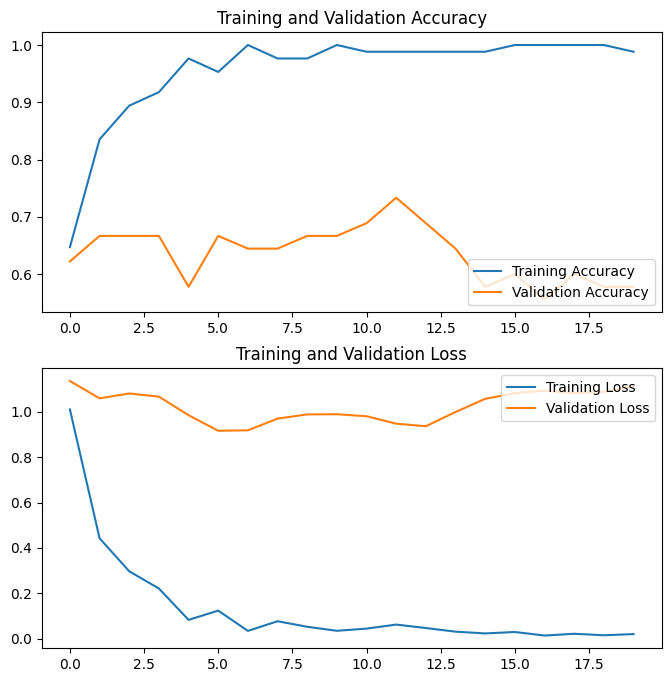

In [138]:
## Plot results
visualize_model_results(ENB3_2nd_ENB3_hist)